# Exploratory Data Analysis and Machine Learning by using medical data

Recent advancements in data science render scientists capable of sorting, managing and analyzing large amounts of data more effectively and efficiently. One of the sectors where these new technologies have been applied is the healthcare industry, which is increasingly becoming more data-reliant due to vast quantities of patient and medical data. As a result, medical practices and patient care are significantly improved.

In this notebook, we will implement various techniques regarding the Exploratory Data Analysis (EDA) of medical data from different datasets.  

As a first step, let's import all necessary packages of this notebook:

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from chainconsumer import ChainConsumer
import time
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.utils import  shuffle

import joblib

## 1st Dataset

First, we will import a dataset that contains the height and weight of people as well as their sex (male/female). We will also print out basic information about this dataset.

In [134]:
start = time.time()
df = pd.read_csv("height_weight.csv")
end = time.time()

print('Loading dataset in', end-start)
df.tail()

Loading dataset in 0.0031180381774902344


,sex,height,weight
4226,2,65.19,114.68
4227,1,67.30,183.39
4228,2,63.69,167.53
4229,2,62.66,136.99
4230,2,59.98,111.56


In [135]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     4231 non-null   int64  
 1   height  4231 non-null   float64
 2   weight  4231 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 99.3 KB


,sex,height,weight
count,4231.000000,4231.000000,4231.000000
mean,1.540061,66.903607,174.095122
std,0.498451,4.313004,38.896171
min,1.000000,55.400000,96.590000
25%,1.000000,63.730000,144.315000
50%,2.000000,66.630000,170.100000
75%,2.000000,69.970000,198.660000
max,2.000000,79.610000,298.440000


We can group the data based on the sex (male/female) and find the mean and median of height and weight.

In [136]:
df.groupby("sex").agg(["mean", "median"])

height              weight        
          mean  median        mean  median
sex                                       
1    69.927497  69.945  192.847554  187.55
2    64.328337  64.290  158.124779  150.37

We can reasonably conclude, as expected, that males are taller than females and that they weigh much more!! 

A histogram with the height and weight may give useful information about their relationship.

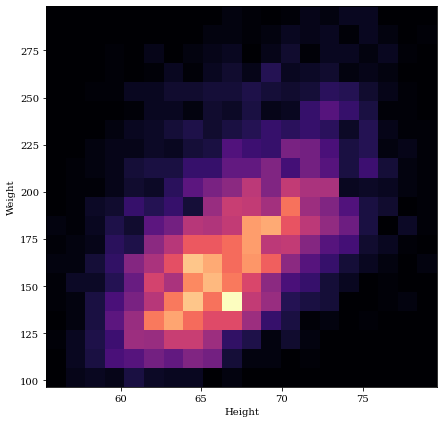

In [137]:
plt.figure(figsize=(7, 7));
plt.hist2d(df["height"], df["weight"], bins=20, cmap="magma")
plt.xlabel("Height")
plt.ylabel("Weight");

Since this histogram seems quite noisy, we can try to create a contour plot based on these values.

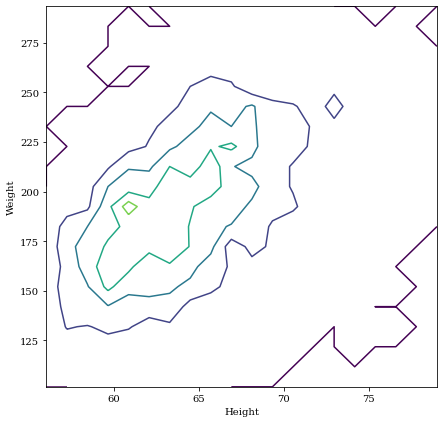

In [138]:
hist, x_edge, y_edge = np.histogram2d(df["height"], df["weight"], bins=20)

#Calculate the average for every bin
x_center = 0.5 * (x_edge[1:] + x_edge[:-1])
y_center = 0.5 * (y_edge[1:] + y_edge[:-1])


#levels: number of different lines
plt.figure(figsize=(7, 7));
plt.contour(x_center, y_center, hist, levels=4)
plt.xlabel("Height")
plt.ylabel("Weight");

We don't have enough data thus,we don't get smooth results.

We can also try Kernel Density Estimation (KDE) Plot.


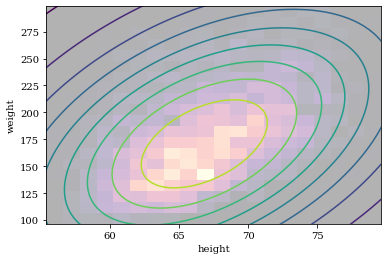

In [139]:
'''w_method: bandwidth method --> a parameter of Gaussian kernel

#Inner circle indicates the peak of our distribution
'''
sns.kdeplot(x = df["height"], y = df["weight"], cmap="viridis", bw_method=2);
plt.hist2d(df["height"], df["weight"], bins=20, cmap="magma", alpha=0.3);

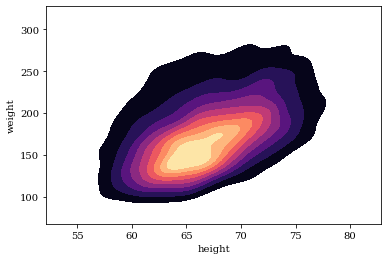

In [140]:
sns.kdeplot(x = df["height"], y = df["weight"], cmap="magma", shade=True);

However, a scatter plot is normally fairly informative and very fast to plot.

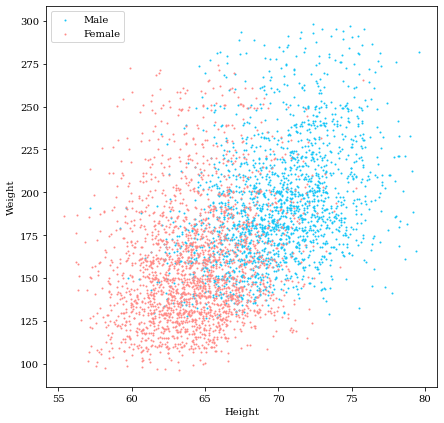

In [141]:
m = df["sex"] == 1
plt.figure(figsize=(7, 7));
plt.scatter(df.loc[m, "height"], df.loc[m, "weight"], c="#16c6f7", s=1, label="Male")
plt.scatter(df.loc[~m, "height"], df.loc[~m, "weight"], c="#ff8b87", s=1, label="Female")
plt.xlabel("Height")
plt.ylabel("Weight")
plt.legend(loc=2);

In [142]:
params = ["height", "weight"]
male = df.loc[m, params].values
female = df.loc[~m, params].values
male.shape

(1946, 2)

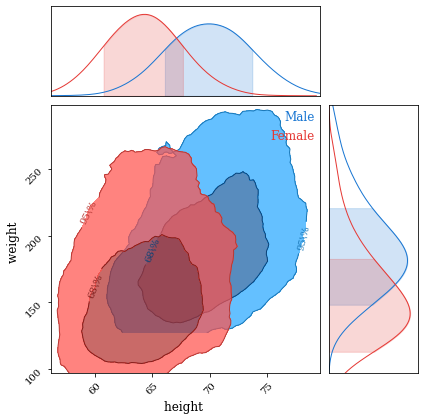

In [143]:
c = ChainConsumer()
c.add_chain(male, parameters=params, name="Male", kde=1.0, color="b")
c.add_chain(female, parameters=params, name="Female", kde=1.0, color="r")
c.configure(contour_labels="confidence", usetex=False)
c.plotter.plot(figsize=2.0);

Inner polygon refers to 65% of the sample whereas outer polygon refers to 99% of the sample.

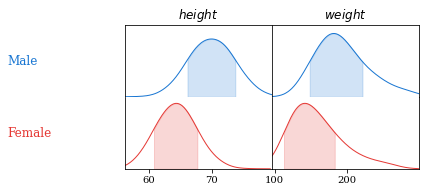

In [144]:
#It plots each category based on every variable separately
c.plotter.plot_summary(figsize=2.0);

So far, we saw several methods of analyzing data using several packages of Python. We can go on now with a new dataset.

## 2st Dataset

The second dataset of this analysis concerns certain diagnostic measurements originated from the National Institute of Diabetes and Digestive and Kidney Diseases [Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database). This dataset was obtained from Kaggle. More specifically, all patients here are females at least 21 years old of Pima Indian heritage. The dataset consists of several medical predictor variables and one **target variable, Outcome**. **Predictor variables** includes the **number of pregnancies** the patient has had, their **BMI**, **insulin level**, **age**, and so on. 

Next, we will import the desired datased by using pandas package as a dataframe and we will have a first look of the contained columns.

In [145]:
start = time.time()
df_original = pd.read_csv("Diabetes.csv")
end =time.time()
print('Loading dataset in', end-start)

df_original.tail()

Loading dataset in 0.002730131149291992


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


We notice that there are some columns, apart from those of Pregnacies and Outcome, that contain zero values. So, we can replace them with NAN values so that we can ommit these measurements later on.

In [146]:
cols = [c for c in df_original.columns if c not in ["Pregnancies", "Outcome"]]
df2 = df_original.copy()
df2[cols] = df2[cols].replace({0: np.NaN})
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50.0,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31.0,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32.0,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


We can also get a better summary of the imported data.

In [147]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 54.1 KB


### Basic statistics of imported data

We can quickly get information about the imported data by applying **describe** to the dataframe. This produces min and max values of each column, their mean and standard deviation as well as the percentiles of 25,50 and 75 respectively.

In [148]:
df3 = df2.dropna()
df3.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Scatter Matrices

Now, a scatter plot between all columns may give a better intuition about their relationship.

/home/gadolias/anaconda3/envs/my_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


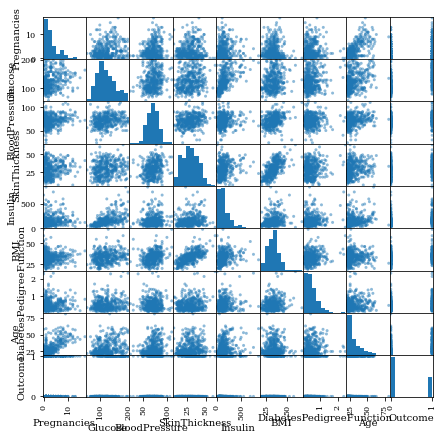

In [149]:
pd.plotting.scatter_matrix(df3, figsize=(7, 7));

We can create again this scatter plot, but this time by illustrating the Outcome of each example (has/has not Diabetes). 

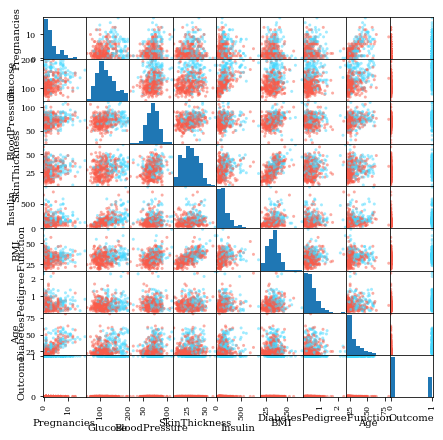

In [150]:
colors = df3["Outcome"].map(lambda x: "#44d9ff" if x else "#f95b4a")
pd.plotting.scatter_matrix(df3, figsize=(7,7), color=colors);

We can see that some variables have a lot of scatter and some are correlated (ie there is a direction in their scatter).

### Correlation Plots

We can examine the correlation of all predictors in order to easily quantify which variables / attributes are correlated with others.

In [151]:
df3.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.198291,0.213355,0.093209,0.078984,-0.025347,0.007562,0.679608,0.256566
Glucose,0.198291,1.000000,0.210027,0.198856,0.581223,0.209516,0.140180,0.343641,0.515703
BloodPressure,0.213355,0.210027,1.000000,0.232571,0.098512,0.304403,-0.015971,0.300039,0.192673
SkinThickness,0.093209,0.198856,0.232571,1.000000,0.182199,0.664355,0.160499,0.167761,0.255936
Insulin,0.078984,0.581223,0.098512,0.182199,1.000000,0.226397,0.135906,0.217082,0.301429
BMI,-0.025347,0.209516,0.304403,0.664355,0.226397,1.000000,0.158771,0.069814,0.270118
DiabetesPedigreeFunction,0.007562,0.140180,-0.015971,0.160499,0.135906,0.158771,1.000000,0.085029,0.209330
Age,0.679608,0.343641,0.300039,0.167761,0.217082,0.069814,0.085029,1.000000,0.350804
Outcome,0.256566,0.515703,0.192673,0.255936,0.301429,0.270118,0.209330,0.350804,1.000000


Heatmaps can also be useful in order to investigate the correlation between predictor variables.

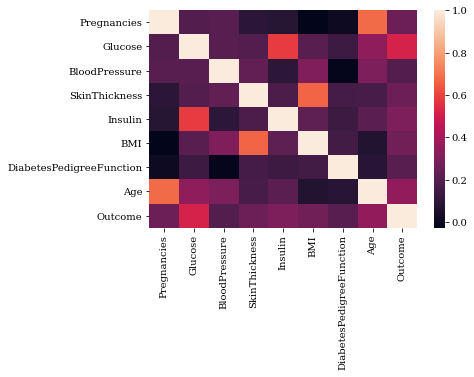

In [152]:
sns.heatmap(df3.corr());

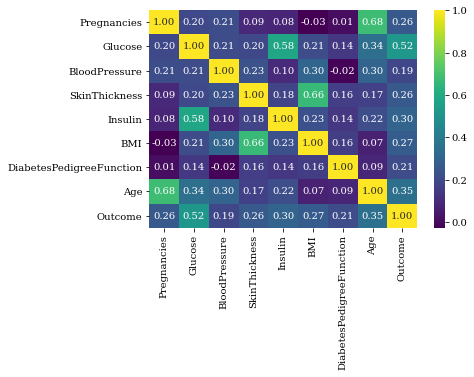

In [153]:
sns.heatmap(df3.corr(), annot=True, cmap="viridis", fmt="0.2f");

Last heatmap allows us to point out the most correlated and anti-correlated attributes. Some might just be common sense - Pregnancies v Age for example - but some might give us real insight into the data.

If we cared about Glucose, BMI and Age primarily, we could get rid of the other columns.

In [154]:
df4 = df3[["Glucose", "BMI", "Age", "Outcome"]]

In [155]:
df4.head()

,Glucose,BMI,Age,Outcome
3,89.0,28.1,21.0,0
4,137.0,43.1,33.0,1
6,78.0,31.0,26.0,1
8,197.0,30.5,53.0,1
13,189.0,30.1,59.0,1


In [156]:
df4.describe()

,Glucose,BMI,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000
mean,122.627551,33.086224,30.864796,0.331633
std,30.860781,7.027659,10.200777,0.471401
min,56.000000,18.200000,21.000000,0.000000
25%,99.000000,28.400000,23.000000,0.000000
50%,119.000000,33.200000,27.000000,0.000000
75%,143.000000,37.100000,36.000000,1.000000
max,198.000000,67.100000,81.000000,1.000000


At this point, we will find a row with any number of zeros and remove it.

In [157]:
df4 = df4.fillna(0)
df5 = df4.loc[~(df2[df2.columns[:-1]] == 0).any(axis=1)]
df5.describe()
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 3 to 765
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Glucose  336 non-null    float64
 1   BMI      336 non-null    float64
 2   Age      336 non-null    float64
 3   Outcome  336 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 13.1 KB


One final thing we could do is to group the data based on the outcome. It might make it easier to look for patterns in diagnoses.

In [158]:
df5.groupby("Outcome").mean()

,Glucose,BMI,Age
Outcome,,,
0,111.146667,31.052444,28.964444
1,144.846847,34.820721,37.657658


In general, the higher your glucose level, the more overweight you are, and the older you are, the greater your chance of being diagnosed with diabetes. Which, perhaps, is not that surprising.

We can do also find other useful information by using the groupby statement:

In [159]:
df5.groupby("Outcome").agg({"Glucose": "mean", "BMI": "median"})

,Glucose,BMI
Outcome,,
0,111.146667,30.9
1,144.846847,34.3


In [160]:
df5.groupby("Outcome").agg(["mean", "median"])

Glucose               BMI               Age       
               mean median       mean median       mean median
Outcome                                                       
0        111.146667  108.0  31.052444   30.9  28.964444   25.0
1        144.846847  145.0  34.820721   34.3  37.657658   36.0

We can export this dataset into a new .csv file.

In [161]:
df5.to_csv("clean_diabetes.csv", index=False)

### Outliers

Sometimes our data is not nice enough to simply have a NaN or zero value to make it easy to tell what we should remove. Sometimes our data has outliers in it. So let's see how we can identify these points. We will examine, for example, Glucose and Age predictor variables.

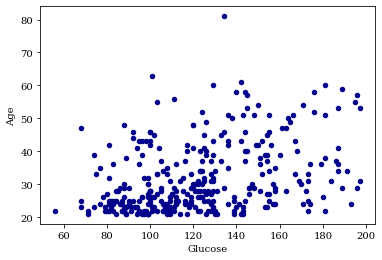

In [162]:
ax1 = df5.plot.scatter(x='Glucose', y='Age', c='DarkBlue')

In [163]:
df6 = df5[["Glucose", "Age"]]
df6.head()
new = df6.to_numpy()

For the detection of the outliers, we will use the Local Outlier Factor method of sklearn package.

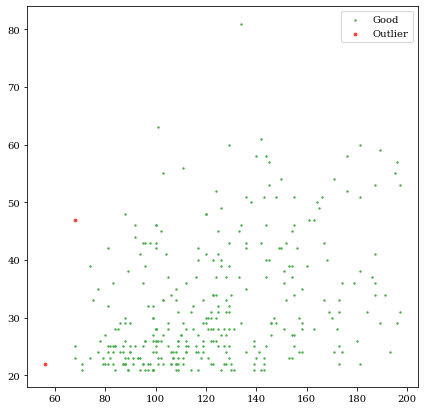

In [164]:

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.005)
good = lof.fit_predict(new) == 1
plt.figure(figsize=(7, 7));
plt.scatter(new[good, 0], new[good, 1], s=2, label="Good", color="#4CAF50")
plt.scatter(new[~good, 0], new[~good, 1], s=8, label="Outlier", color="#F44336")
plt.legend();

## Creation of machine learning model in order to predict diabetes cases based on unseen data

As a next step, we will create a machine learning model which will enable the prediction of a positive/negative diabates case based on new and unseen Glucose, BMI and Age data. Since there are only two classes of target variables (Outcome = {0,1}), we will need algorithms that generate models of binary classification.

Initially, we shuffle, prepare and split our data into training and test dataset.

In [165]:
# Shuffle again and re-index
dataframe = shuffle(df5)
dataframe = df5.sample(frac=1).reset_index(drop=True)

In [166]:
# Set X and y
X = dataframe.iloc[:,:-1]
y = dataframe.iloc[:,-1]

In [167]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

 ### ML models and algorithms
 
 Then, we train several models by using different algoritghms in order to decide which model performs better to unseen data.

KNeighborsClassifier
****Results****
Fitting time: 0.000643
Accuracy: 76.47%
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        48
           1       0.60      0.60      0.60        20

    accuracy                           0.76        68
   macro avg       0.72      0.72      0.72        68
weighted avg       0.76      0.76      0.76        68

Confusion matrix:
 [[40  8]
 [ 8 12]]


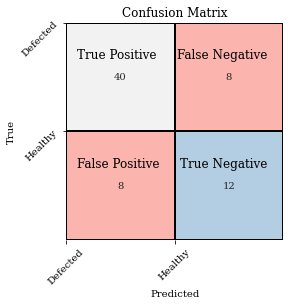

Log Loss: 1.8411
SVC
****Results****
Fitting time: 0.00465
Accuracy: 70.59%
Classification report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83        48
           1       0.00      0.00      0.00        20

    accuracy                           0.71        68
   macro avg       0.35      0.50      0.41        68
weighted avg       0.50      0.71      0.58        68

Confusion matrix:
 [[48  0]
 [20  0]]


/home/gadolias/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


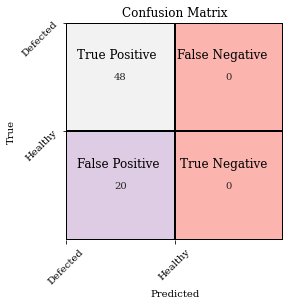

Log Loss: 0.39918
NuSVC
****Results****
Fitting time: 0.00565
Accuracy: 85.29%
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90        48
           1       0.78      0.70      0.74        20

    accuracy                           0.85        68
   macro avg       0.83      0.81      0.82        68
weighted avg       0.85      0.85      0.85        68

Confusion matrix:
 [[44  4]
 [ 6 14]]


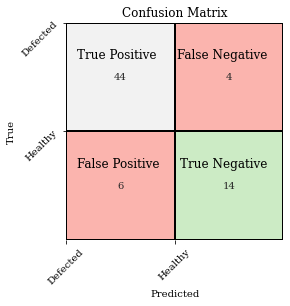

Log Loss: 0.39904
DecisionTreeClassifier
****Results****
Fitting time: 0.000958
Accuracy: 85.29%
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        48
           1       0.75      0.75      0.75        20

    accuracy                           0.85        68
   macro avg       0.82      0.82      0.82        68
weighted avg       0.85      0.85      0.85        68

Confusion matrix:
 [[43  5]
 [ 5 15]]


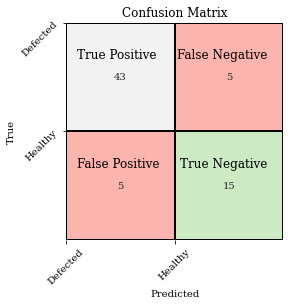

Log Loss: 1.7908
RandomForestClassifier
****Results****
Fitting time: 0.0101
Accuracy: 86.76%
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91        48
           1       0.79      0.75      0.77        20

    accuracy                           0.87        68
   macro avg       0.84      0.83      0.84        68
weighted avg       0.87      0.87      0.87        68

Confusion matrix:
 [[44  4]
 [ 5 15]]


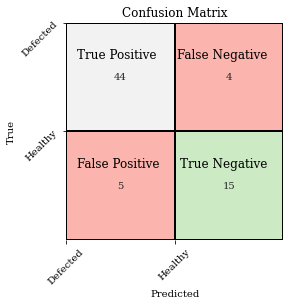

Log Loss: 0.37482
AdaBoostClassifier
****Results****
Fitting time: 0.0573
Accuracy: 80.88%
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.87        48
           1       0.77      0.50      0.61        20

    accuracy                           0.81        68
   macro avg       0.79      0.72      0.74        68
weighted avg       0.80      0.81      0.80        68

Confusion matrix:
 [[45  3]
 [10 10]]


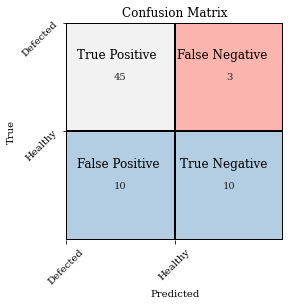

Log Loss: 0.64057
GradientBoostingClassifier
****Results****
Fitting time: 0.0653
Accuracy: 83.82%
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        48
           1       0.76      0.65      0.70        20

    accuracy                           0.84        68
   macro avg       0.81      0.78      0.80        68
weighted avg       0.83      0.84      0.83        68

Confusion matrix:
 [[44  4]
 [ 7 13]]


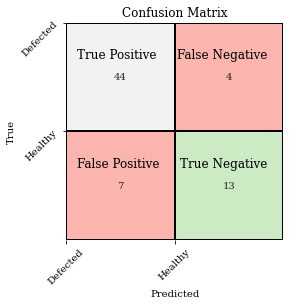

Log Loss: 0.4282
GaussianNB
****Results****
Fitting time: 0.00133
Accuracy: 82.35%
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        48
           1       0.70      0.70      0.70        20

    accuracy                           0.82        68
   macro avg       0.79      0.79      0.79        68
weighted avg       0.82      0.82      0.82        68

Confusion matrix:
 [[42  6]
 [ 6 14]]


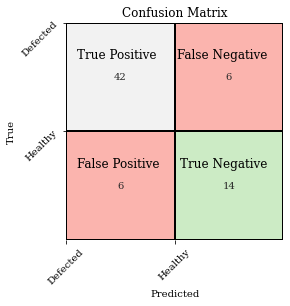

Log Loss: 0.37833
LinearDiscriminantAnalysis
****Results****
Fitting time: 0.00132
Accuracy: 85.29%
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90        48
           1       0.78      0.70      0.74        20

    accuracy                           0.85        68
   macro avg       0.83      0.81      0.82        68
weighted avg       0.85      0.85      0.85        68

Confusion matrix:
 [[44  4]
 [ 6 14]]


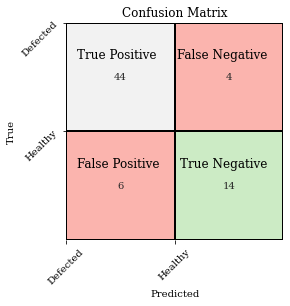

Log Loss: 0.37675
QuadraticDiscriminantAnalysis
****Results****
Fitting time: 0.000571
Accuracy: 83.82%
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        48
           1       0.74      0.70      0.72        20

    accuracy                           0.84        68
   macro avg       0.81      0.80      0.80        68
weighted avg       0.84      0.84      0.84        68

Confusion matrix:
 [[43  5]
 [ 6 14]]


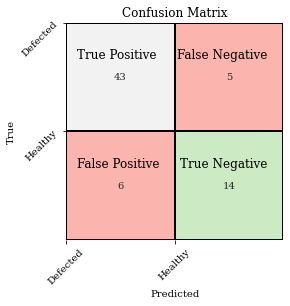

Log Loss: 0.39575
MLPClassifier
****Results****
Fitting time: 0.205
Accuracy: 85.29%
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        48
           1       0.75      0.75      0.75        20

    accuracy                           0.85        68
   macro avg       0.82      0.82      0.82        68
weighted avg       0.85      0.85      0.85        68

Confusion matrix:
 [[43  5]
 [ 5 15]]


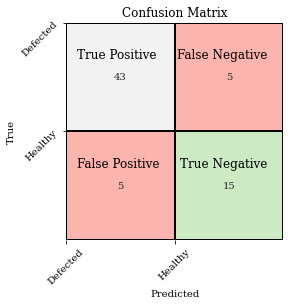

Log Loss: 0.37723


In [168]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True, cache_size=1000),
    NuSVC(probability=True, cache_size=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(alpha=1)]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss", "Time"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    
    timer = end-start
    print("Fitting time: {:.3}".format(timer))
    
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.2%}".format(acc))
    
    print("Classification report:\n" , classification_report(y_test, train_predictions))
    
    cm = confusion_matrix(y_test, train_predictions)
    print("Confusion matrix:\n" , cm)
    #sns.set_context('poster')
    plt.title('Confusion Matrix')
    #sns.set_context('paper', font_scale=1.0)
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.1, linecolor='black', cbar=False, cmap=plt.cm.Pastel1, robust=True, square=True)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.yticks(np.arange(2), ("Defected", "Healthy"), rotation=45)
    plt.xticks(np.arange(2), ("Defected", "Healthy"), rotation=45)
    plt.text(x=0.1, y=0.3, s='True Positive', fontsize=12, color='black', va='center')
    plt.text(x=1.02, y=0.3, s='False Negative', fontsize=12, color='black', va='center')
    plt.text(x=0.1, y=1.3, s='False Positive', fontsize=12, color='black', va='center')
    plt.text(x=1.05, y=1.3, s='True Negative', fontsize=12, color='black', va='center')
    plt.show()
    
    
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.5}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll, timer]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

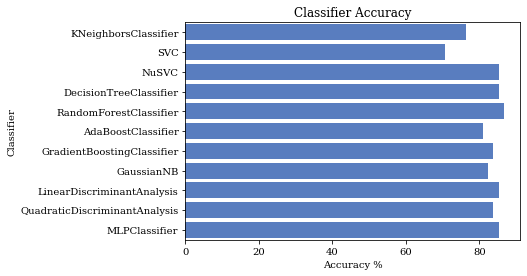

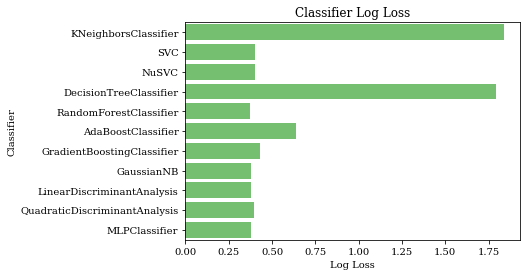

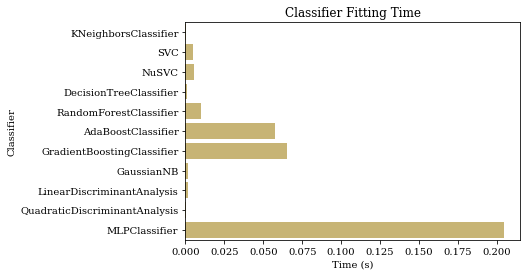

In [169]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")


plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Time', y='Classifier', data=log, color="y")

plt.xlabel('Time (s)')
plt.title('Classifier Fitting Time')
plt.show()

Based on the classifiers' accuracy, the **trained model** that performed the **best accuracy** was **Random Forest classifier** with **accuracy = 86.76%%**, by showing low Fitting time: **Fitting time= 0.0101 sec**. This model, **however**, showed high **log loss** : 0.37482.

### Best model

Best Model | Accuracy (%) | Log Loss | Fitting Time (s)
--- | --- | --- | --- |
K Nearest Neighbour | 86.76%% | 0.37482 | 0.0101 sec


## Export final model

In [170]:
final_model = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
final_model.fit(X,y)

NuSVC(cache_size=1000, probability=True)

In [171]:
joblib.dump(final_model,'final_model.pkl')

['final_model.pkl']

In [172]:
joblib.dump(list(X.columns),'column_names.pkl')

['column_names.pkl']

In [173]:
col_names = joblib.load('column_names.pkl')

In [174]:
col_names

['Glucose', 'BMI', 'Age']

In [175]:
loaded_model = joblib.load('final_model.pkl')

In [176]:
loaded_model.predict([[111.146667,30.9,32.0]])

array([0])